In [1]:
from __future__ import annotations

from pathlib import Path

import sys

sys.path.append("../")

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.optimization_data import TrainingData, PredictionData
from wufam.metrics.metrics import calc_sharpe
from wufam.features.pca_analysis import PCAAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_6_M
FACTORS_DATASET = Dataset.FACTORS_M
WEIGHTING = "value_weighted"
FACTOR_ANNUALIZE = 12

## 1.1


In [2]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / FACTORS_DATASET,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

## 1.2


In [3]:
from wufam.strategies.heuristics.equally_weighted import EWStrategy
from wufam.strategies.estimated.mean_var import MeanVariance
from wufam.strategies.estimated.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

ew_strategy = EWStrategy()

In [4]:
from wufam.estimation.mean.sample_mu_estimator import SampleMuEstimator
from wufam.estimation.covariance.sample_cov_estimator import SampleCovEstimator

mv_strategy = MeanVariance(
    mu_estimator=SampleMuEstimator(),
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [5]:
from wufam.estimation.covariance.shrinkage.pca_cov_estimator import PCACovEstimator

min_var_strategy = MinVariance(
    cov_estimator=PCACovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [6]:
training_data = TrainingData(
    simple_excess_returns=factors_df,
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

In [7]:
prediction_data = PredictionData()

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In [8]:
ew_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [9]:
mv_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,-1.443996,-0.264279,3.017976,0.896614,-0.333317,-0.872997


In [10]:
min_var_weights.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,-1.435176,-0.488751,2.653299,0.945826,0.995038,-1.670235


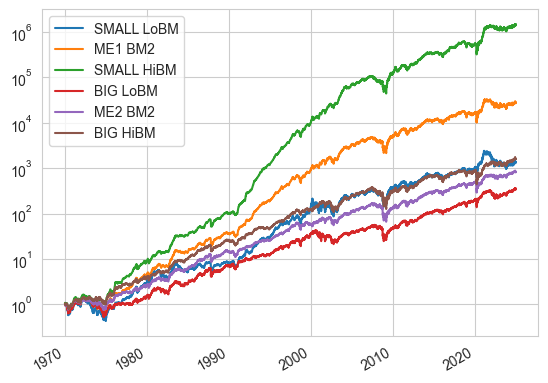

In [11]:
factors_df.add(1).cumprod().plot(logy=True);

In [12]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=factors_df,
    rf_rate=rf,
    factor_annualize=252,
)

1.592247434944696

In [13]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=factors_df,
    rf_rate=rf,
    factor_annualize=252,
)

2.3601159396244373

In [14]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=factors_df,
    rf_rate=rf,
    factor_annualize=252,
)

2.392787774361941

## 1.3.


In [15]:
split_date = factors_df.index[len(factors_df) // 2]

training_data = TrainingData(
    simple_excess_returns=factors_df.loc[:split_date],
)

ew_strategy.fit(training_data)
mv_strategy.fit(training_data)
min_var_strategy.fit(training_data)

ew_weights = ew_strategy(prediction_data)
mv_weights = mv_strategy(prediction_data)
min_var_weights = min_var_strategy(prediction_data)

In-sample.


In [16]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=factors_df.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

2.3123958333741967

In [17]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=factors_df.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

3.9355252479774565

In [18]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=factors_df.loc[:split_date],
    rf_rate=rf,
    factor_annualize=252,
)

3.7270226298391442

Out-of-sample.


In [19]:
calc_sharpe(
    weights=ew_weights,
    excess_ret=factors_df.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

0.5284882214073725

In [20]:
calc_sharpe(
    weights=mv_weights,
    excess_ret=factors_df.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

1.1566128407324294

In [21]:
calc_sharpe(
    weights=min_var_weights,
    excess_ret=factors_df.loc[split_date:],
    rf_rate=rf,
    factor_annualize=252,
)

1.122396240159677

## 1.6 PCA Analysis


In [22]:
plt.style.use('default')
sns.set_palette("husl")

In [23]:
# Reload the module to get latest changes
import importlib
import wufam.features.pca_analysis
importlib.reload(wufam.features.pca_analysis)
from wufam.features.pca_analysis import PCAAnalysis


In [24]:
# Create PCA analysis instance following proper methodology
pca_analysis = PCAAnalysis(n_components=None)  

print(f"Assets: {factors_df.columns.tolist()}")

# Fit PCA
pca_analysis.fit(factors_df)

Assets: ['SMALL LoBM', 'ME1 BM2', 'SMALL HiBM', 'BIG LoBM', 'ME2 BM2', 'BIG HiBM']
Eigenvalues: [0.0007 0.     0.     0.     0.     0.    ]
Explained Variance Ratio:
[0.8939466  0.05301499 0.03680013 0.00757936 0.00511255 0.00354637]


Principal Component Loadings (First 3 Components):
     SMALL LoBM  ME1 BM2  SMALL HiBM  BIG LoBM  ME2 BM2  BIG HiBM
PC1      0.4517   0.3859      0.3267    0.4336   0.3989    0.4396
PC2      0.5833   0.3309      0.2760   -0.2219  -0.3900   -0.5222
PC3      0.2298  -0.2075     -0.4575    0.7098   0.0244   -0.4364


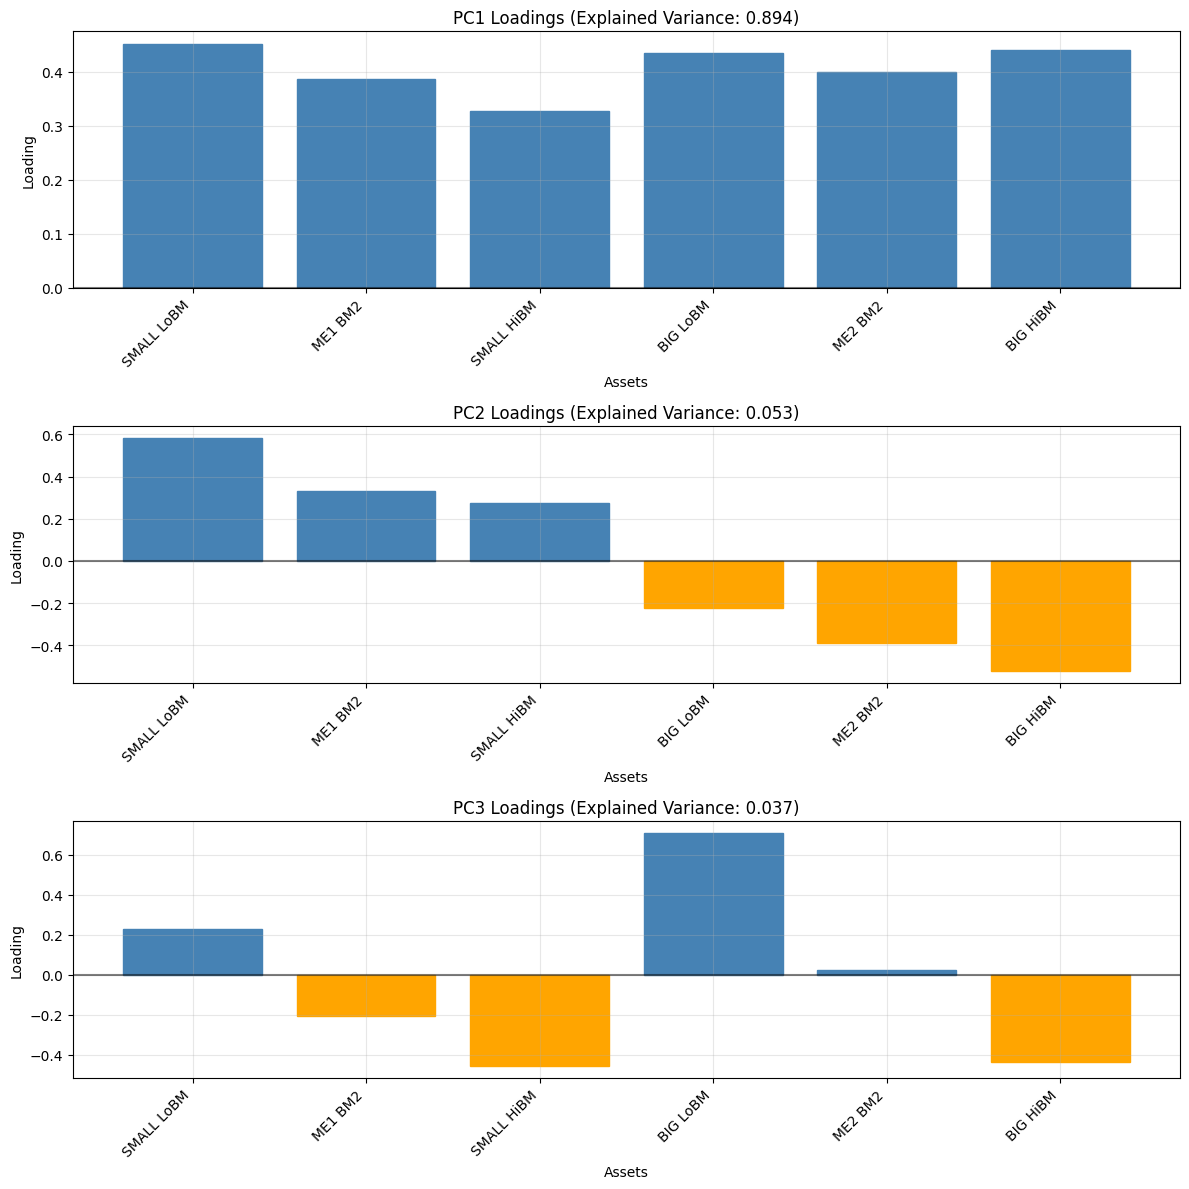

In [25]:
# Get and display the loadings for first 3 principal components
components_df = pca_analysis.get_components(3)
print("Principal Component Loadings (First 3 Components):")
print(components_df.round(4))

fig = pca_analysis.plot_component_loadings(3)
plt.show()

In [26]:
ff_factors_file = PATH / Dataset.RF

# Read the Fama-French factors directly
ff_factors = pd.read_csv(
    ff_factors_file,
    skiprows=4,
    skipfooter=3,
    index_col=0,
    engine='python'
)

try:
    # Try to convert as if it's in YYYYMMDD format
    ff_factors.index = pd.to_datetime(ff_factors.index.astype(str), format='%Y%m%d')
except ValueError:
    try:
        # If that fails, try ISO format or let pandas infer
        ff_factors.index = pd.to_datetime(ff_factors.index)
        print("Converted using automatic format detection")
    except Exception as e:
        print(f"Date conversion failed: {e}")
        # Show the actual format of the index
        print("Sample index values:", ff_factors.index[:5].tolist())

# Filter by date range and convert to decimal
ff_factors = ff_factors.loc[START:END] / 100

print("\nAvailable Fama-French Factors:")
print(ff_factors.columns.tolist())


Available Fama-French Factors:
['Mkt-RF', 'SMB', 'HML', 'RF']


Correlations between Principal Components and Fama-French Factors:
     Mkt-RF     SMB     HML
PC1  0.9233  0.2392 -0.0114
PC2 -0.2173  0.7380 -0.2972
PC3  0.2094 -0.1841 -0.8552


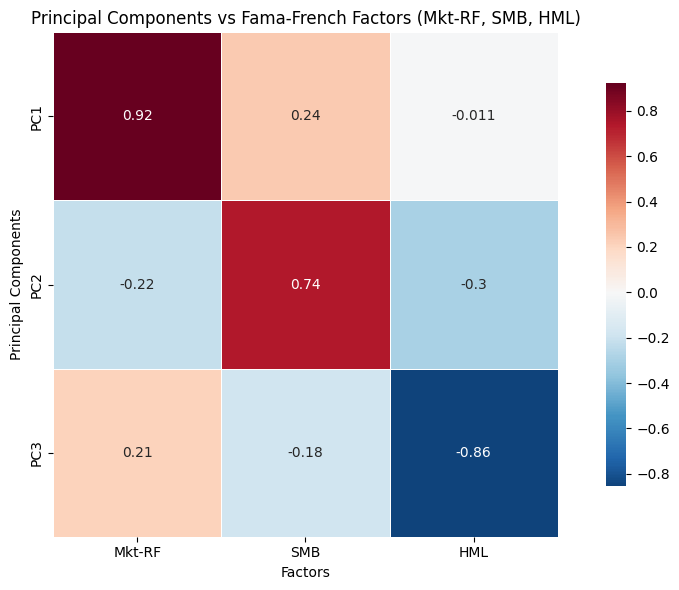

In [27]:
# Analyze relationship between PCs and the three main Fama-French factors
ff_main_factors = ff_factors[['Mkt-RF', 'SMB', 'HML']]
correlations = pca_analysis.analyze_factor_relationship(ff_main_factors, 3)
print("Correlations between Principal Components and Fama-French Factors:")
print(correlations.round(4))

# Plot correlation heatmap
fig = pca_analysis.plot_factor_correlations(
    correlations, 
    title="Principal Components vs Fama-French Factors (Mkt-RF, SMB, HML)"
)
plt.show()

### Interpretation of Results

The PCA analysis reveals the relationship between the first three principal components and the Fama-French factors:

1. **PC1 (First Principal Component)**:

   - Captures the largest portion of variance in the portfolio returns
   - Correlation with Market factor (Mkt-RF) indicates market-wide movements
   - High loadings suggest this component represents systematic market risk

2. **PC2 (Second Principal Component)**:

   - Correlation with SMB (Small Minus Big) factor suggests this captures size effects
   - Loadings pattern shows differential exposure across size-sorted portfolios
   - Represents the size premium in portfolio returns

3. **PC3 (Third Principal Component)**:
   - Correlation with HML (High Minus Low) factor indicates value effects
   - Shows the value premium across book-to-market sorted portfolios
   - The data-specific factor (value effect) captured by this component

The high correlations between PCs and factors confirm that the principal components successfully capture the three main sources of variation in portfolio returns: **market risk**, **size effect**, and **value effect**.
